In [97]:
import csv
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [98]:
def moving_average(arr, window_size):
    i = 0
    moving_averages = []

    while i < len(arr) - window_size + 1:
        window = arr[i : i + window_size]
        window_average = round(sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1

    return moving_averages

In [273]:
opponent = "GDX"

opponent_sum = 0
DTR_sum = 0
opc, dtrc = 0, 0

df = pd.DataFrame(columns=["DTR", opponent])
norm_df = pd.DataFrame(columns=["DTR", opponent])

for i in range(1,11):
    norm_batch = pd.DataFrame(columns=["DTR", opponent])
    with open(f"experiment-data/00-00-10-00-00-00-10:{i}.csv", newline="") as csvfile:
        reader = csv.reader(csvfile)
        
        for row in reader:
            if opponent == "AA":
                opp_profit = float(row[4])
                dtr_profit = float(row[11])
            else:
                opp_profit = float(row[11])
                dtr_profit = float(row[4])

            if dtr_profit > opp_profit * 3 or dtr_profit * 3 < opp_profit:
                continue

            opponent_sum += opp_profit
            DTR_sum += dtr_profit

            if dtr_profit > opp_profit:
                dtrc += 1
            else:
                opc += 1

            new_row = pd.DataFrame({opponent: opp_profit, "DTR": dtr_profit}, index=[0])
            df = pd.concat([df, new_row], ignore_index=True)
            norm_batch = pd.concat([norm_batch, new_row], ignore_index=True)

    batch_min_dtr = norm_batch["DTR"].min()
    batch_max_dtr = norm_batch["DTR"].max()

    batch_max_opp = norm_batch[opponent].max()
    batch_min_opp = norm_batch[opponent].min()

    norm_batch["DTR"] = (norm_batch["DTR"] - batch_min_dtr) / (batch_max_dtr - batch_min_dtr)
    norm_batch[opponent] = (norm_batch[opponent] - batch_min_opp) / (batch_max_opp - batch_min_opp)
    
    norm_df = pd.concat([norm_df, norm_batch], ignore_index=True)

In [274]:
def calc_confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    # Calculate the standard error and margin of error for a 95% confidence interval
    se = std / np.sqrt(n)
    moe = stats.t.ppf(0.95, df=n-1) * se

    # Calculate the confidence interval
    ci_lower = mean - moe
    ci_upper = mean + moe

    return (ci_lower, ci_upper)

ci_lower, ci_upper = calc_confidence_interval(df['DTR'])
print(f"The 90% confidence interval for the DTR mean is ({ci_lower:.2f}, {ci_upper:.2f})")
print('DTR mean:', int(df['DTR'].mean()), 'DTR std:', int(df['DTR'].std()))

ci_lower, ci_upper = calc_confidence_interval(df[opponent])
print(f"The 90% confidence interval for the {opponent} mean is ({ci_lower:.2f}, {ci_upper:.2f})")
print(f'{opponent} mean:', int(df[opponent].mean()), f'{opponent} std:', int(df[opponent].std()))

The 90% confidence interval for the DTR mean is (924.05, 1011.80)
DTR mean: 967 DTR std: 582
The 90% confidence interval for the GDX mean is (715.81, 791.53)
GDX mean: 753 GDX std: 502


In [275]:
# Print the result
print(f"{opponent}_sum: {int(opponent_sum)}")
print(f"DTR_sum: {int(DTR_sum)}")

print("DTR wins:", dtrc, f"{opponent} wins:", opc, "Delta wins:", dtrc - opc)

print(f"{opponent} mean profit: {int(df[opponent].mean())}, and standard deviation: {int(df[opponent].std())}")
print(f"DTR mean profit: {int(df['DTR'].mean())}, and standard deviation: {int(df['DTR'].std())}")

perc = (dtrc / (dtrc + opc)) * 100
print("Ratio is:", f"{perc}:{100-perc}")

GDX_sum: 360253
DTR_sum: 462667
DTR wins: 360 GDX wins: 118 Delta wins: 242
GDX mean profit: 753, and standard deviation: 502
DTR mean profit: 967, and standard deviation: 582
Ratio is: 75.31380753138075:24.686192468619254


In [276]:
for col in df.columns:
    shapiro_test = stats.shapiro(df[col])
    print("Test for col", col, ":", shapiro_test)
    print("Test for scaled col", col, ":", stats.shapiro(norm_df[col]))
    print("Test for scaled col", col, ":", stats.normaltest(norm_df[col]), "\n")
    print("Test for col", col, ":", stats.kstest(norm_df[col], stats.norm.cdf), "\n")

Test for col DTR : ShapiroResult(statistic=0.9600654244422913, pvalue=4.2647277376239856e-10)
Test for scaled col DTR : ShapiroResult(statistic=0.9339108467102051, pvalue=1.0422963355035883e-13)
Test for scaled col DTR : NormaltestResult(statistic=525.557917861602, pvalue=7.525722080058814e-115) 

Test for col DTR : KstestResult(statistic=0.5, pvalue=5.012085502032366e-111) 

Test for col GDX : ShapiroResult(statistic=0.92003333568573, pvalue=3.082852432739042e-15)
Test for scaled col GDX : ShapiroResult(statistic=0.9640837907791138, pvalue=2.0472457062936655e-09)
Test for scaled col GDX : NormaltestResult(statistic=101.9027278304907, pvalue=7.449100028998725e-23) 

Test for col GDX : KstestResult(statistic=0.5, pvalue=5.012085502032366e-111) 



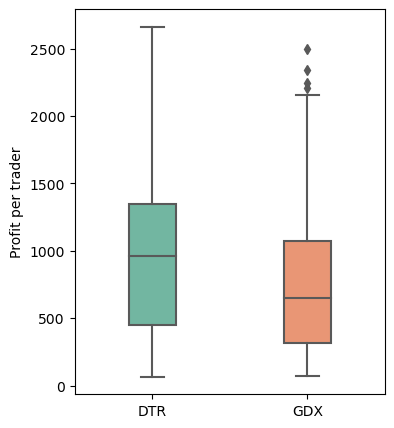

In [277]:
fig, ax = plt.subplots(figsize=(4, 5))
# ax.set_title(f"Distribution of profits")
ax.set_ylabel(f"Profit per trader")
sns.boxplot(data=df, width=0.3, ax=ax, palette=sns.color_palette("Set2"))
plt.savefig("dist-gdx-otm.png", dpi=300, bbox_inches="tight")
plt.show()

In [278]:
print(stats.ttest_ind(norm_df["DTR"], norm_df[opponent]))
print(stats.ttest_rel(norm_df["DTR"], norm_df[opponent]), '\n')

print(stats.wilcoxon(df["DTR"], df[opponent]))
print(stats.mannwhitneyu(df["DTR"], df[opponent]))
print(stats.kruskal(df["DTR"], df[opponent]))

Ttest_indResult(statistic=2.436347318286569, pvalue=0.015018474937806043)
Ttest_relResult(statistic=4.1252087953896, pvalue=4.370354481970831e-05) 

WilcoxonResult(statistic=20913.0, pvalue=2.6987098605549776e-33)
MannwhitneyuResult(statistic=138972.0, pvalue=6.903803880083416e-09)
KruskalResult(statistic=33.56307971631815, pvalue=6.898988461384933e-09)


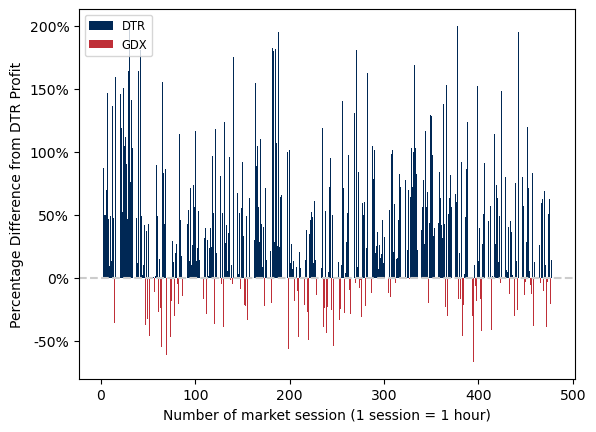

In [279]:
plt.xlabel("Number of market session (1 session = 1 hour)")
plt.ylabel('Percentage Difference from DTR Profit')
x_ticks = [i for i in range(1, len(df["DTR"]) + 1)]

diff_profits = (df["DTR"] - df[opponent]) / np.abs(df[opponent]) * 100
# print([i for i in diff_profits if i < 0])
colors = ["#002855" if p > 0 else "#BF2F38" for p in diff_profits]

plt.bar(x_ticks, diff_profits, color=colors)
plt.axhline(y=0, color="#CCCCCC", linestyle="--")

plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)

dtr_label = plt.Rectangle((0, 0), 1, 1, fc="#002855", edgecolor='none')
opponent_label = plt.Rectangle((0, 0), 1, 1, fc="#BF2F38", edgecolor='none')
plt.legend([dtr_label, opponent_label], ['DTR', opponent], loc='upper left', fontsize='small')
plt.savefig("wins-zip-otm.png", dpi=300, bbox_inches="tight")

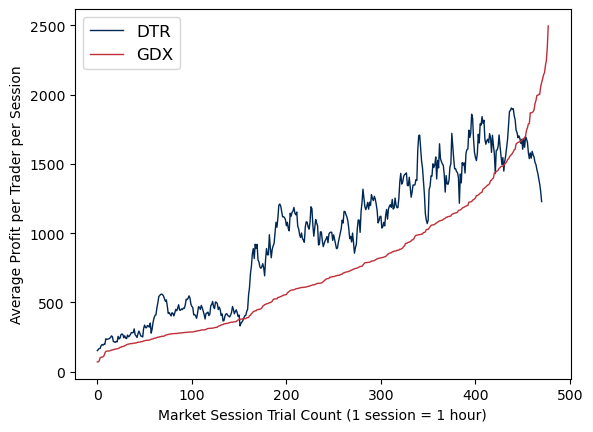

In [280]:
fig, ax = plt.subplots()

plt.xlabel("Market Session Trial Count (1 session = 1 hour)")
plt.ylabel('Average Profit per Trader per Session')

df_sorted = df.sort_values(opponent)

ax.plot(moving_average(df_sorted["DTR"],8), color="#002855", label="DTR", linewidth=1)
ax.plot(moving_average(df_sorted[opponent],1), color="#BF2F38", label=opponent, linewidth=1)

legend = ax.legend(loc="upper left", shadow=False, fontsize="large")
plt.savefig("profit-gdx-bgr.png", dpi=300, bbox_inches="tight")

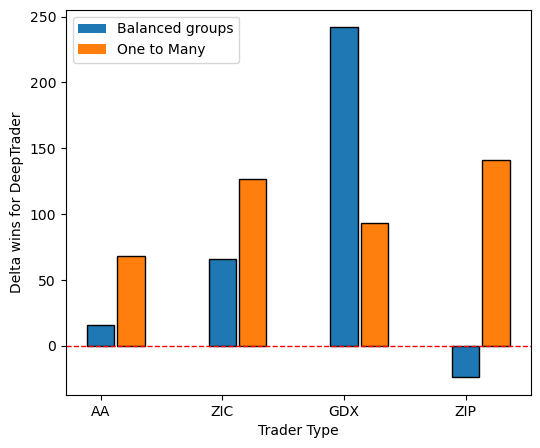

In [281]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data
data = [[16, 68], [66, 127], [242, 93], [-24, 141]]
colors = ['#1f77b4', '#ff7f0e']

# Set the x-axis labels
labels = ['AA', 'ZIC', 'GDX', 'ZIP']

# Set the labels for each color
color_labels = ['Balanced groups', 'One to Many']

# Create the figure and set the size
fig, ax = plt.subplots(figsize=(6, 5))

bar_width = 0.45
spacing = 0.05

# Create the bar plot
for i in range(len(data)):
    ax.bar(i*2+bar_width+spacing, data[i][0], width=bar_width, color=colors[0], edgecolor='black')
    ax.bar(i*2+1, data[i][1], width=bar_width, color=colors[1], edgecolor='black')

# Set the x-axis labels
ax.set_xticks(np.arange(len(labels))*2+0.5)
ax.set_xticklabels(labels)

# Set the legend
dtr_label = plt.Rectangle((0, 0), 1, 1, fc="#1f77b4", edgecolor='none')
opponent_label = plt.Rectangle((0, 0), 1, 1, fc="#ff7f0e", edgecolor='none')
ax.legend([dtr_label, opponent_label], color_labels, loc='upper left', fontsize='medium')

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel("Trader Type")
ax.set_ylabel("Delta wins for DeepTrader")

plt.savefig("headtohead.png", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

